## Parameter Fitting to a Simple Series Reaction

jbr book reference: [Figure A.10](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/fig-html/appendix/fig-A-10.html)

Reaction is $A \xrightarrow[]{k_1} B \xrightarrow[]{k_2} C$

Data simulated for $A$, $B$, and $C$ over time (with added noise) based on:
$ c_{A0} = 1, c_{B0} = 0, c_{c0} = 0, k_1 = 2, k_2 = 1$

The above parameters are also the parameters that will be fitted based on the data

In [18]:
from kipet import KipetModel
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t

In [2]:
dirname = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/'
filename = dirname + 'ABC_data.csv'
C_data = pd.read_csv(filename, index_col = 0)

In [3]:
C_data.columns = ['A', 'B', 'C']
C_data.head()

,A,B,C
t,,,
0.000,0.957,-0.031,-0.015
0.263,0.557,0.330,0.044
0.526,0.342,0.512,0.156
0.789,0.224,0.499,0.310
1.053,0.123,0.428,0.454


In [4]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

r1.add_component('A', state = 'concentration', init = 1.0)
r1.add_component('B', state = 'concentration', init = 0.0)
r1.add_component('C', state = 'concentration', init = 0.0)

r1.add_parameter('k1',init = 5.0, bounds=(0.0,10.0))
r1.add_parameter('k2',init = 5.0, bounds=(0.0,10.0))
r1.add_parameter('ca0', init = 1.0, bounds = (0.5, 1.5))
r1.add_parameter('cb0', init = 0.0, bounds = (0.0, 1.5))
r1.add_parameter('cc0', init = 0.0, bounds = (0.0, 1.5))

In [5]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs

r1.add_equations(rule_odes)
r1.set_times(0.0, 5.0)

In [6]:
r1.add_dataset('C_data', category = 'concentration', data = C_data)

In [7]:
r1.create_pyomo_model()

Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
0.0 5.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.

In [8]:
# explicitly add constraints for initial conditions and relax the auto-imposed initial conditions by builder
r1.model.ca0_cons = pyo.Constraint(expr = r1.model.Z[0, 'A'] == r1.model.P['ca0'])
r1.model.cb0_cons = pyo.Constraint(expr = r1.model.Z[0, 'B'] == r1.model.P['cb0'])
r1.model.cc0_cons = pyo.Constraint(expr = r1.model.Z[0, 'C'] == r1.model.P['cc0'])
r1.model.init_conditions_c.deactivate()

In [9]:
r1.settings.collocation.nfe = 50
r1.settings.collocation.ncp = 3
r1.settings.collocation.scheme = 'LAGRANGE-RADAU'
r1.settings.parameter_estimator['solver'] = 'k_aug'
r1.settings.solver.linear_solver = 'ma27'

In [10]:
r1.run_opt()

No variance information for A found, setting equal to unity
No variance information for B found, setting equal to unity
No variance information for C found, setting equal to unity
        0.10 seconds required to write file
        0.10 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      908
             

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018

: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 908
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 903
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 5
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601035646991736 at var_i=300
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601035646952257 at var_i=301
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 903, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 3906
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 360
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.025073
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 848
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG


RESULTS
Z:
                  A         B         C
0.000000  0.984597  0.000722  0.010591
0.010195  0.964592  0.020619  0.010699
0.042405  0.904016  0.079590  0.012304
0.065750  0.862505  0.118812  0.014592
0.075945  0.844981  0.135060  0.015868
...            ...       ...       ...
4.821811  0.000060  0.016539  0.979311
4.868500  0.000054  0.015800  0.980055
4.888889  0.000052  0.015488  0.980369
4.953311  0.000046  0.014542  0.981322
5.000000  0.000042  0.013892  0.981976

[151 rows x 3 columns]

Cm:
            A      B      C
0.000  0.957 -0.031 -0.015
0.263  0.557  0.330  0.044
0.526  0.342  0.512  0.156
0.789  0.224  0.499  0.310
1.053  0.123  0.428  0.454
1.316  0.079  0.396  0.556
1.579  0.035  0.303  0.651
1.842  0.029  0.287  0.658
2.105  0.025  0.221  0.750
2.368  0.017  0.148  0.854
2.632 -0.002  0.182  0.845
2.895  0.009  0.116  0.893
3.158 -0.023  0.079  0.942
3.421  0.006  0.078  0.899
3.684  0.016  0.059  0.942
3.947  0.014  0.036  0.991
4.211 -0.009  0.014  0.988
4.4

In [11]:
r1.results.show_parameters


The estimated parameters are:
k1 2.013554902149728
k2 0.9855453689401997
ca0 0.9845971387036323
cb0 0.0007216177935954641
cc0 0.010590852706107375


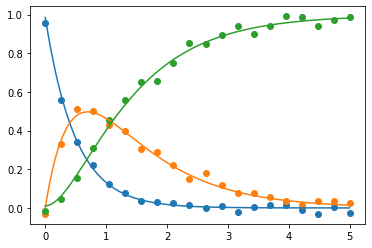

In [13]:
fig, ax = plt.subplots()
for c in ['A', 'B', 'C']:
    ax.scatter(r1.results.Cm.index, r1.results.Cm[c])
    ax.plot(r1.results.Z.index, r1.results.Z[c])

In [ ]:
results_pyomo.objective

In [16]:
# since kipet outputs reduced hessian which equals covariance if right sigma values are specified. 
# since we just specified sigma=1, we need to adjust the covariance matrix output from KIPET to get the 
# estimated covariance matrix
mse = r1.results.objective / (C_data.shape[0]*3 - 5)
cov_est = 2 * mse * r1.results.parameter_covariance
cov_est

array([[ 3.22114734e-03, -2.49664962e-04,  3.13496631e-04,
        -4.07274772e-04,  2.26864109e-06],
       [-2.49664962e-04,  5.04590444e-04,  5.34365918e-05,
         3.48579061e-05, -1.43987286e-04],
       [ 3.13496631e-04,  5.34365918e-05,  2.13144635e-04,
        -1.66218450e-04, -4.08394326e-05],
       [-4.07274772e-04,  3.48579061e-05, -1.66218450e-04,
         2.60480549e-04, -7.70090754e-05],
       [ 2.26864109e-06, -1.43987286e-04, -4.08394326e-05,
        -7.70090754e-05,  1.37115869e-04]])

In [19]:
dof = (C_data.shape[0]*3 - 5)
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_est))
conf_delta

array([0.11373987, 0.04501704, 0.029258  , 0.0323441 , 0.02346666])

In [21]:
# confidence limits of parameters
i = 0
for k, v in r1.results.P.items():
    print(f"{k}, {v - conf_delta[i]:.2f}, {v + conf_delta[i]:.2f}")
    i = i + 1

k1, 1.90, 2.13
k2, 0.94, 1.03
ca0, 0.96, 1.01
cb0, -0.03, 0.03
cc0, -0.01, 0.03
